In [9]:
import scipy.linalg
import scipy.optimize
import sys
import numpy as np
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_function as tfu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.theodolite_utils as ttfu


def R_z(theta):
    R = np.eye(4,4)
    R[0,:2] = [np.cos(theta), -np.sin(theta)]
    R[1,:2] = [np.sin(theta), np.cos(theta)]
    return R

def T_z(theta, t):
    T = R_z(theta)
    T[:3,3] = t
    return T
    
def dist(p,q):
    return np.linalg.norm(p-q)

def cost_fun(p1s_l, p2s_l, p3s_l, xi_12, xi_13, d_truth12, d_truth13, d_truth23):
    T12 = exp_T(xi_12)
    T13 = exp_T(xi_13)
    c=0
    c += sum([(dist(p1,T12@p2)-d_truth12)**2 for p1,p2 in zip(p1s_l, p2s_l)])
    c += sum([(dist(p1,T13@p3)-d_truth13)**2 for p1,p3 in zip(p1s_l, p3s_l)])
    c += sum([(dist(T12@p2,T13@p3)-d_truth23)**2 for p2,p3 in zip(p2s_l, p3s_l)])
    
    return c

def vee(xi):
    T = np.zeros((4,4))
    T[:3,:3] = np.array([[ 0,     -xi[2], xi[1]],
                        [ xi[2], 0,     -xi[0]],
                        [-xi[1], xi[0], 0]])
    T[:3,3] = xi[3:]
    return T
    
def exp_T(xi):
    return scipy.linalg.expm(vee(xi))

def resection_with_2_known_points(point1, point2, station_height, measures_first_point, measures_second_point):
    print(measures_first_point[2])
    station_z = ((point1[2] - measures_first_point[2]*np.sin(measures_first_point[1])) + (point2[2] - measures_second_point[2]*np.sin(measures_second_point[1])))/2
    
    # find the position of the total station using the intersection of 2 circles given by the measurements of the prism position.
    radius_1 = measures_first_point[2]*np.cos(measures_first_point[1])
    radius_2 = measures_second_point[2]*np.cos(measures_second_point[1])
    print("radius_1: ", radius_1)
    print("radius_2: ", radius_2)
    
    delta_x = point2[0] - point1[0]
    delta_y = point2[1] - point1[1]
    
    # find the y value based on the intersection of 2 circles aligned in x (same value of x)
    y = (np.power(radius_1, 2) - np.power(radius_2, 2) - np.power(point1[1], 2) + np.power(point2[1], 2))/(2*delta_y)
    
    # find the possible values of x based on the quadratic formula and the circle formula knowing y
    A = 1
    B = -2*point1[0]
    C = np.power(point1[0], 2) + np.power(y, 2) + np.power(point1[1], 2) - 2*y*point1[1] - np.power(radius_1, 2)
    
    x_1 = (-B + np.sqrt(np.power(B, 2) - 4*A*C))/2*A
    
    x_2 = (-B - np.sqrt(np.power(B, 2) - 4*A*C))/2*A    
    
    # find the yaw offset to get the measures back in the prism's frame
    theta_station__prism_1 = np.arctan2(abs(point1[0]-x_1), abs(point1[1]-y))
    if (x_1 > point1[0]):
        yaw_1 =  measures_first_point[0] - (3*np.pi/2 - theta_station__prism_1)
    else:
        yaw_1 =  measures_first_point[0] - (3*np.pi/2 + theta_station__prism_1)
        
    theta_station__prism_2 = np.arctan2(abs(point1[0]-x_2), abs(point1[1]-y))
    if (x_2 > point1[0]):
        yaw_2 =  measures_first_point[0] - (3*np.pi/2 - theta_station__prism_2)
    else:
        yaw_2 =  measures_first_point[0] - (3*np.pi/2 + theta_station__prism_2)
        
    station_pos_complete_1 = np.array([x_1, y, station_z, 0, 0, yaw_1])    
    station_pos_complete_2 = np.array([x_2, y, station_z, 0, 0, yaw_2])
    
    return station_pos_complete_1, station_pos_complete_2

In [10]:
# easy test of resection function
pilier_A = np.array([1000, 1000 - np.sqrt(np.power(548.578,2) - np.power(2.374, 2)), 100-2.374])
pilier_D = np.array([1000, 1000, 100])

print(pilier_A)
print(pilier_D)

station_1_height = 1.83
station_1_measures_first_point = np.array([])
station_1_measures_second_point = np.array([])

station_2_height = 1.56
station_2_measures_first_point = np.array([])
station_2_measures_second_point = np.array([])

station_3_height = 1.70
station_3_measures_first_point = np.array([])
station_3_measures_second_point = np.array([])
#point_1 = np.array([0,0,3])
#point_2 = np.array([0,-4,3])
#station_height = 2
#measures_first_point = np.array([np.pi/4, np.arctan2(1,np.sqrt(8)), 3])
#measures_second_point = np.array([7*np.pi/4, np.arctan2(1,np.sqrt(8)), 3])

#station_pos1, station_pos2 = resection_with_2_known_points(point_1, point_2, station_height, measures_first_point, measures_second_point)

station_1_pos1, station_1_pos2 = resection_with_2_known_points(pilier_D, pilier_A, station_1_height, station_1_measures_first_point, station_1_measures_second_point)

station_2_pos1, station_2_pos2 = resection_with_2_known_points(pilier_D, pilier_A, station_2_height, station_2_measures_first_point, station_2_measures_second_point)

station_3_pos1, station_3_pos2 = resection_with_2_known_points(pilier_D, pilier_A, station_3_height, station_3_measures_first_point, station_3_measures_second_point)

print("first possible position: ", station_pos1)
print("second possible position: ", station_pos2)
print("yaws en deg: ", station_pos1[-1]*180/np.pi, station_pos2[-1]*180/np.pi)

[1000.          451.42713683   97.626     ]
[1000 1000  100]


IndexError: index 2 is out of bounds for axis 0 with size 0

In [2]:
%matplotlib notebook
ttfu = importlib.reload(ttfu)
#path = "./data/raw_data/20220505_cones/corrected_raw_data/GP-10-20_2_"
path = "./data/raw_data/L-1-6_"
#path = "./data/raw_data/20220505_cones/corrected_raw_data/SGP-500-1-2_"
#path = "./data/raw_data/SGP-1000-2-6_"

trimble_1 = ttfu.read_prediction_data_resection_csv_file(path+"1.csv")
trimble_2 = ttfu.read_prediction_data_resection_csv_file(path+"2.csv")
trimble_3 = ttfu.read_prediction_data_resection_csv_file(path+"3.csv")

FileNotFoundError: [Errno 2] No such file or directory: './data/raw_data/L-1-6_1.csv'

In [140]:
print(len(np.array(trimble_1)))
print(len(np.array(trimble_2)))
print(len(np.array(trimble_3)))

2004
2004
2004


In [141]:
ttfu = importlib.reload(ttfu)
rate = 10
index1 = ttfu.find_not_moving_points_GP(np.array(trimble_1), 10, 1/rate) 
index2 = ttfu.find_not_moving_points_GP(np.array(trimble_2), 10, 1/rate) 
index3 = ttfu.find_not_moving_points_GP(np.array(trimble_3), 10, 1/rate)  

In [142]:
#p1s_l = np.array(trimble_1)[:,1:5]
#p2s_l = np.array(trimble_2)[:,1:5]
#p3s_l = np.array(trimble_3)[:,1:5]
p1s_l = np.array(trimble_1)[:,1:5]
p2s_l = np.array(trimble_2)[:,1:5]
p3s_l = np.array(trimble_3)[:,1:5]
print(len(np.array(trimble_1).T[0]),len(np.array(trimble_2).T[0]),len(np.array(trimble_3).T[0]))
print(len(p1s_l),len(p2s_l),len(p3s_l))

2004 2004 2004
2004 2004 2004


<IPython.core.display.Javascript object>


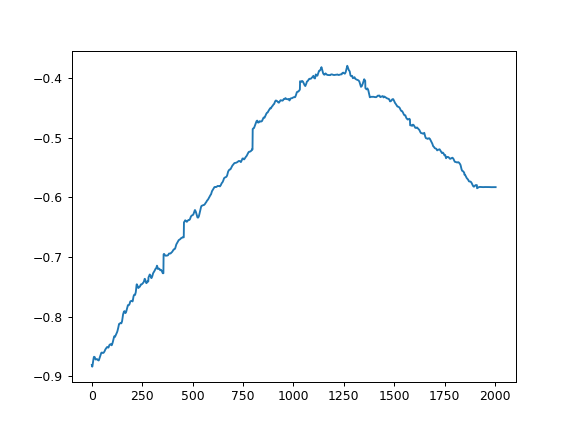

In [143]:
%matplotlib notebook

#plt.figure(figsize=(10,3))
#plt.scatter(p1s_l[:,0],p1s_l[:,2])
#plt.scatter(p2s_l[:,0],p2s_l[:,2])
#plt.scatter(p3s_l[:,0],p3s_l[:,2])
plt.plot(p2s_l[:,2])

plt.show()

In [144]:
import time
# 12 03 2022
#Dist_prism_12 = 0.8860734460339026
#Dist_prism_13 = 0.8303896290142598
#Dist_prism_23 = 1.0393117663247973

# 14 03 2022 / 16 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 05 05 2022
Dist_prism_12 = 0.3819811991689936
Dist_prism_13 = 0.4426382054042266
Dist_prism_23 = 0.2564685508415531

# 31 03 2022
#Dist_prism_12 = 0.8873171656784946
#Dist_prism_13 = 0.8272212117473343
#Dist_prism_23 = 1.0379270641796363

# 27 04 2022
#Dist_prism_12 = 0.8856608085851714
#Dist_prism_13 = 0.8264452483880412
#Dist_prism_23 = 1.0384219210289538

# 23 05 2022
#Dist_prism_12 = 0.3851913749758221
#Dist_prism_13 = 0.4433899497583272
#Dist_prism_23 = 0.25861327466684897

f = lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, Dist_prism_23)

start_time = time.time()
res = scipy.optimize.minimize(lambda x: cost_fun(p1s_l, p2s_l, p3s_l, x[:6], x[6:], Dist_prism_12, Dist_prism_13, 
                            Dist_prism_23), x0=np.zeros((12,1)), tol=1e-8)

stop_time = time.time()
print(stop_time - start_time)
print(res.fun)
xi_12 = res.x[:6]
xi_13 = res.x[6:] 
T12 = exp_T(xi_12)
T13 = exp_T(xi_13)

193.0663251876831
0.15590649384411212


In [145]:
print(len(p1s_l))
print(res.fun/len(p1s_l))

2004
7.779765161881842e-05


In [146]:
p1s_r = p1s_l
p2s_r = T12@p2s_l.T
p3s_r = T13@p3s_l.T

#p1s_r = np.array(trimble_1)[:,1:5]
#p2s_r = T12@np.array(trimble_2)[:,1:5].T
#p3s_r = T13@np.array(trimble_3)[:,1:5].T

print(T12)
print(T13)

[[ 0.7991318   0.60115147  0.0022945   1.35792274]
 [-0.60113557  0.79906766  0.01126538  0.52818966]
 [ 0.00493874 -0.01038183  0.99993391  0.24963809]
 [ 0.          0.          0.          1.        ]]
[[ 0.29507198  0.95545939  0.00546714  1.58307843]
 [-0.95479457  0.29464111  0.03942013  1.34041032]
 [ 0.03605349 -0.01685177  0.99920777  0.10151842]
 [ 0.          0.          0.          1.        ]]


<IPython.core.display.Javascript object>


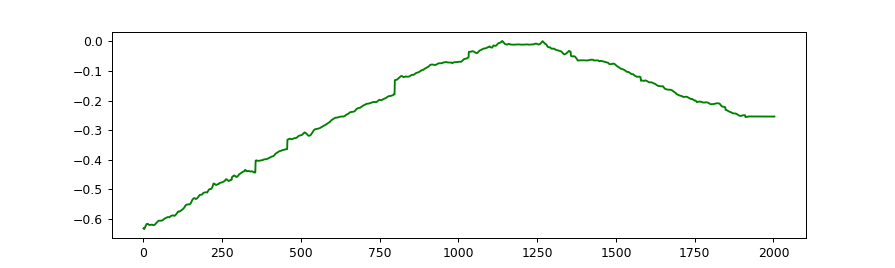

In [147]:
%matplotlib notebook

p2s_rarr = np.array(p2s_r).T
p3s_rarr = np.array(p3s_r).T

plt.figure(figsize=(10,3))
#plt.scatter(p1s_r[:,0],p1s_r[:,1], color='b')
#plt.scatter(p2s_rarr[:,0],p2s_rarr[:,2], color='r')
#plt.scatter(p3s_rarr[:,1],p3s_rarr[:,2], color='g')
plt.plot(p2s_rarr[:,2], color='g')
plt.show()

<IPython.core.display.Javascript object>


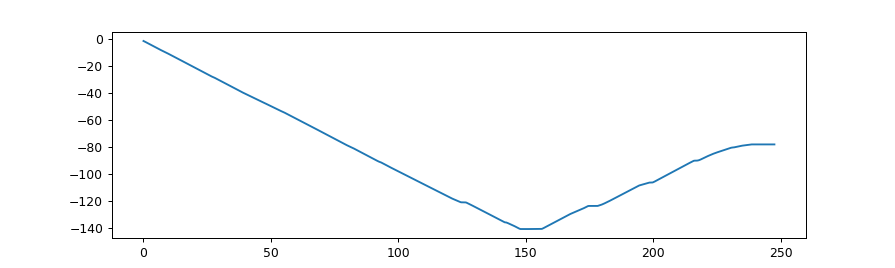

In [149]:
plt.figure(figsize=(10,3))
offset_timestamp = min(np.array(trimble_1)[0,0],np.array(trimble_2)[0,0],np.array(trimble_3)[0,0])
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,0])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,0])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,0])
plt.show()

<IPython.core.display.Javascript object>


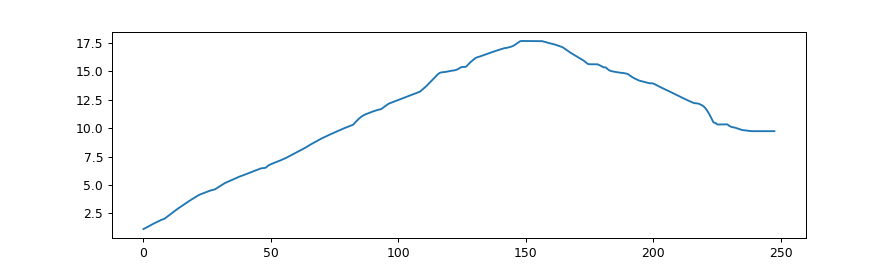

In [150]:
plt.figure(figsize=(10,3))
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,1])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,1])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,1])
plt.show()

<IPython.core.display.Javascript object>


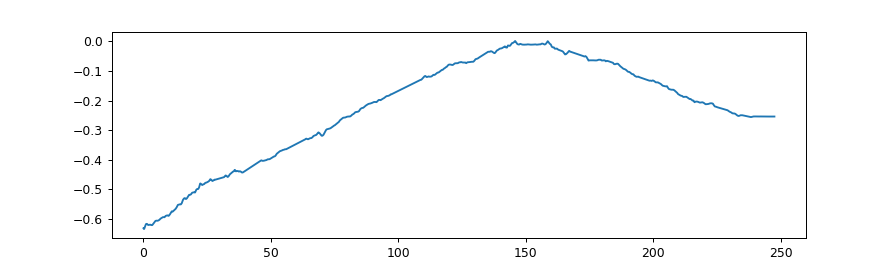

In [151]:
plt.figure(figsize=(10,3))
#plt.plot(np.array(trimble_1)[:,0]-offset_timestamp,p1s_r[:,2])
plt.plot(np.array(trimble_2)[:,0]-offset_timestamp,p2s_rarr[:,2])
#plt.plot(np.array(trimble_3)[:,0]-offset_timestamp,p3s_rarr[:,2])
plt.show()

In [152]:
dist_prism = []
timestamp = np.array(trimble_1)[:,0]
for i in range(0,len(timestamp)-1):
    dp1 = abs(np.linalg.norm(p1s_r[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_12)*1000
    dp2 = abs(np.linalg.norm(p1s_r[i,0:3]-p3s_rarr[i,0:3])-Dist_prism_13)*1000
    dp3 = abs(np.linalg.norm(p3s_rarr[i,0:3]-p2s_rarr[i,0:3])-Dist_prism_23)*1000
    dist_prism.append(np.array([timestamp[i], dp1, dp2, dp3]))
dist_prism = np.array(dist_prism)

Mean inter-prism [mm]:  3.52 3.92 2.07
Std inter-prism [mm]:  4.29 4.77 2.152


<IPython.core.display.Javascript object>


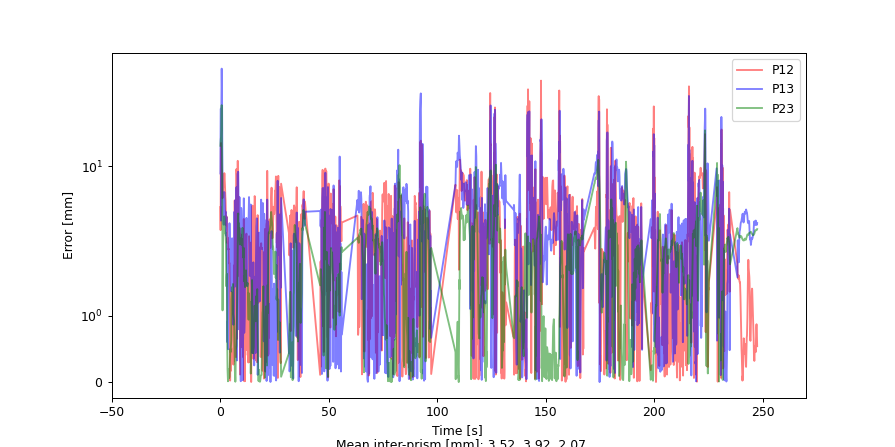

In [153]:
print("Mean inter-prism [mm]: ", round(np.mean(dist_prism[:,1]),2), round(np.mean(dist_prism[:,2]),2), round(np.mean(dist_prism[:,3]),2))
print("Std inter-prism [mm]: ", round(np.std(dist_prism[:,1]),2), round(np.std(dist_prism[:,2]),2), round(np.std(dist_prism[:,3]),3))
plt.figure(figsize=(10,5))
offset_timestamp = min(dist_prism[:,0])
plt.subplot(111)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,1], label="P12", color="red", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,2], label="P13", color="blue", alpha=0.5)
plt.plot(dist_prism[:,0]-offset_timestamp, dist_prism[:,3], label="P23", color="green", alpha=0.5)
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylabel("Error [mm]")
limitx = [-50, 270]
ax.set_xlim(limitx)
ax.set_xlabel("Time [s] \n Mean inter-prism [mm]: " + str(round(np.mean(dist_prism[:,1]),2)) + "  " + str(round(np.mean(dist_prism[:,2]),2)) + "  " + str(round(np.mean(dist_prism[:,3]),2))
             + "\n Std inter-prism [mm]: " + str(round(np.std(dist_prism[:,1]),2)) + "  " + str(round(np.std(dist_prism[:,2]),2)) + "  " + str(round(np.std(dist_prism[:,3]),2)))
plt.savefig("./figs/20220505_cones_dynamic_L-1-6.jpg")
#plt.savefig("./figs/20220505_cones_dynamic.jpg")
#plt.savefig("./figs/20220523_empty.jpg")
plt.show()  

In [126]:
# Convert point data to csv file
ttfu = importlib.reload(ttfu)

# Trajectory total station (time, point data) x3
ttfu.Convert_datap_to_csv(np.array(trimble_1)[:,0], np.array(p1s_r), "./data/prediction/nr_trimble_1.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_2)[:,0], np.array(p2s_rarr), "./data/prediction/nr_trimble_2.csv")
ttfu.Convert_datap_to_csv(np.array(trimble_3)[:,0], np.array(p3s_rarr), "./data/prediction/nr_trimble_3.csv")

Conversion done !
Conversion done !
Conversion done !


In [47]:
ttfu = importlib.reload(ttfu)
save_tf = True
name_file = './data/calibration/tf_automated_resection/20220505_empty_tf_a.csv'
if(save_tf):
    ttfu.save_tf(np.identity(4), T12, T13, name_file)

Conversion done !
